[Complete Guide to Parameter Tuning in XGBoost with codes in Python](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
# XGBoost Article

The data here is taken form the Data Hackathon3.x - http://datahack.analyticsvidhya.com/contest/data-hackathon-3x

## Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 6)

## Load Data:

The data has gone through following pre-processing:
1. City variable dropped because of too many categories
2. DOB converted to Age | DOB dropped
3. EMI_Loan_Submitted_Missing created which is 1 if EMI_Loan_Submitted was missing else 0 | EMI_Loan_Submitted dropped
4. EmployerName dropped because of too many categories
5. Existing_EMI imputed with 0 (median) - 111 values were missing
6. Interest_Rate_Missing created which is 1 if Interest_Rate was missing else 0 | Interest_Rate dropped 
7. Lead_Creation_Date dropped because made little intuitive impact on outcome
8. Loan_Amount_Applied, Loan_Tenure_Applied imputed with missing
9. Loan_Amount_Submitted_Missing created which is 1 if Loan_Amount_Submitted was missing else 0 | Loan_Amount_Submitted dropped 
10. Loan_Tenure_Submitted_Missing created which is 1 if Loan_Tenure_Submitted was missing else 0 | Loan_Tenure_Submitted dropped 
11. LoggedIn, Salary_Account removed
12. Processing_Fee_Missing created which is 1 if Processing_Fee was missing else 0 | Processing_Fee dropped
13. Source - top 2 kept as is and all others combined into different category
14. Numerical and One-Hot-Coding performed

In [ ]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')

In [10]:
train.shape, test.shape

((87020, 51), (37717, 50))

In [4]:
target='Disbursed'
IDcol = 'ID'

In [5]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

## Define a function for modeling and cross-validation

This function will do the following:
1. fit the model
2. determine training accuracy
3. determine training AUC
4. determine testing AUC
5. update n_estimators with cv function of xgboost package
6. plot Feature Importance 

In [6]:
# test_results = pd.read_csv('test_results.csv')
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
#     Predict on testing data:
#     dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
#     results = test_results.merge(dtest[['ID','predprob']], on='ID')
#     print('AUC Score (Test): %f' % metrics.roc_auc_score(results['Disbursed'], results['predprob']))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Step 1- Find the number of estimators for a high learning rate


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.906122
CPU times: user 9.71 s, sys: 1 s, total: 10.7 s
Wall time: 10.7 s


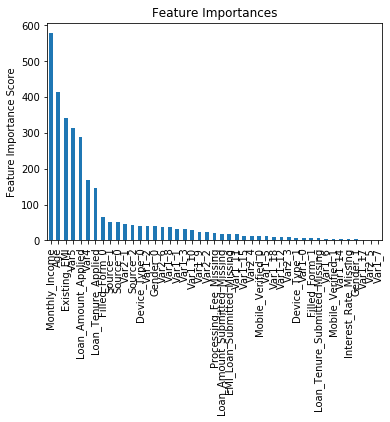

In [7]:
%%time
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        scale_pos_weight=1,
        seed=27,
        predictor = 'gpu_predictor',
        tree_method = 'gpu_hist')
modelfit(xgb1, train, test, predictors)

In [8]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1, seed=27,predictor = 'gpu_predictor', tree_method = 'gpu_hist'), 
                       param_grid = param_test1, scoring='roc_auc', iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

CPU times: user 31.9 s, sys: 5.62 s, total: 37.5 s
Wall time: 37.5 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     predictor='gpu_predictor', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid=False, n_jobs=None,
             param_grid={'max_depth': ran

In [9]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.39500179, 0.39224558, 0.39043722, 0.4819808 , 0.47645674,
         0.47307172, 0.68022122, 0.64153018, 0.61783757, 1.01552505,
         0.86537428, 0.80233378]),
  'std_fit_time': array([0.00721654, 0.00439164, 0.00226656, 0.00442081, 0.00366562,
         0.00598759, 0.0073161 , 0.00775214, 0.00350557, 0.01270153,
         0.00778897, 0.00779535]),
  'mean_score_time': array([0.01068258, 0.01035762, 0.01058998, 0.01035118, 0.01069484,
         0.01037135, 0.01040683, 0.01030903, 0.01050858, 0.01056776,
         0.01123695, 0.01071205]),
  'std_score_time': array([1.03950899e-03, 2.81539373e-04, 8.33102512e-04, 1.19109684e-04,
         8.50771230e-04, 2.47599484e-04, 8.05673635e-05, 1.36113532e-04,
         2.19843464e-04, 9.22845116e-05, 1.45247702e-03, 2.56153557e-04]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, F

In [10]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1,seed=27,predictor = 'gpu_predictor', tree_method = 'gpu_hist'), 
                       param_grid = param_test2, scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

CPU times: user 18.8 s, sys: 3.79 s, total: 22.5 s
Wall time: 22.5 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=2,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     predictor='gpu_predictor', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid=False, n_jobs=None,
             param_grid={'max_depth': [4,

In [11]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.4255929 , 0.41947637, 0.42248077, 0.47240009, 0.47067795,
         0.4686614 , 0.54108386, 0.53509507, 0.53369274]),
  'std_fit_time': array([0.00588868, 0.00262046, 0.00333411, 0.00509351, 0.00391506,
         0.00301415, 0.00549103, 0.00530923, 0.00810215]),
  'mean_score_time': array([0.01011305, 0.01018939, 0.01031504, 0.01024108, 0.01078706,
         0.01017985, 0.01085715, 0.01046796, 0.01025305]),
  'std_score_time': array([5.89123384e-05, 9.80246151e-05, 4.33437491e-04, 1.79937545e-04,
         1.12865301e-03, 1.52252365e-04, 1.07549428e-03, 2.33261915e-04,
         7.67634667e-05]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, 

In [12]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2b = {
    'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1,seed=27, predictor = 'gpu_predictor', tree_method = 'gpu_hist'), 
                       param_grid = param_test2b, scoring='roc_auc',iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

CPU times: user 7.69 s, sys: 1.48 s, total: 9.17 s
Wall time: 9.15 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=2,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     predictor='gpu_predictor', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid=False, n_jobs=None,
             param_grid={'min_child_weigh

In [13]:
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

({'mean_fit_time': array([0.42219391, 0.4223053 , 0.42884717, 0.42208858]),
  'std_fit_time': array([0.00215344, 0.00196742, 0.00237224, 0.00233602]),
  'mean_score_time': array([0.01084614, 0.01034179, 0.01020565, 0.010148  ]),
  'std_score_time': array([1.22745216e-03, 3.14528368e-04, 1.40625867e-04, 5.66709277e-05]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'split0_test_score': array([0.82975179, 0.83341439, 0.83283908, 0.83376333]),
  'split1_test_score': array([0.82717041, 0.8285082 , 0.83040691, 0.83306557]),
  'split2_test_score': array([0.8503026 , 0.84900394, 0.84980568, 0.85010285]),
  'split3_test_score': array([0.84730888, 0.84856294, 0.84894668, 0.84833532]),
  'split4_test_score': array([0.84161906, 0.84096052, 0.83992662, 0

In [14]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1,seed=27, predictor = 'gpu_predictor', tree_method = 'gpu_hist'), 
                       param_grid = param_test3, scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

CPU times: user 9.29 s, sys: 2.05 s, total: 11.3 s
Wall time: 11.3 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=6,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     predictor='gpu_predictor', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid=False, n_jobs=None,
             param_grid={'gamma': [0.0, 0

In [15]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.42327995, 0.42343473, 0.42278461, 0.42114739, 0.42476649]),
  'std_fit_time': array([0.00214075, 0.00237905, 0.00556146, 0.0021828 , 0.002916  ]),
  'mean_score_time': array([0.0112411 , 0.01006808, 0.01009684, 0.01114864, 0.01009169]),
  'std_score_time': array([2.01711597e-03, 1.14923750e-04, 5.25078477e-05, 1.81952751e-03,
         9.55730368e-05]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.82975179, 0.82975179, 0.82975179, 0.82975179, 0.82975179]),
  'split1_test_score': array([0.82717041, 0.82717041, 0.82717041, 0.82717041, 0.82717041]),
  'split2_test_score': array([0.8503026, 0.8503026, 0.8503026, 0.8503026, 0.8503026]),
  'split3_test_score': array([0.84730888, 0.84730888, 0.84730888, 0


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.887453
CPU times: user 10.8 s, sys: 918 ms, total: 11.7 s
Wall time: 11.7 s


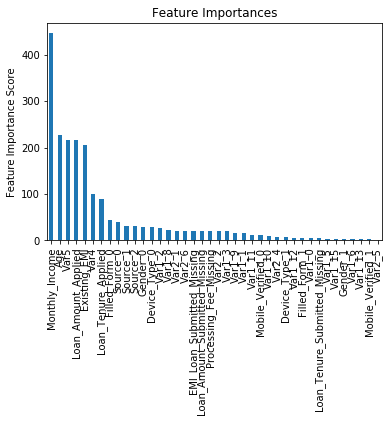

In [16]:
%%time
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        scale_pos_weight=1,
        seed=27,
        predictor = 'gpu_predictor', 
        tree_method = 'gpu_hist')
modelfit(xgb2, train, test, predictors)

Tune subsample and colsample_bytree

In [17]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1,seed=27,predictor = 'gpu_predictor', tree_method = 'gpu_hist'), 
                       param_grid = param_test4, scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

CPU times: user 35.2 s, sys: 7.46 s, total: 42.6 s
Wall time: 42.6 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=6,
                                     missing=None, n_estimators=177, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     predictor='gpu_predictor', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid=False, n_jobs=None,
             param_grid={'colsample_bytre

In [18]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([0.51516876, 0.51748042, 0.50973511, 0.50908895, 0.51462607,
         0.5125217 , 0.5079052 , 0.50667787, 0.51298494, 0.51389799,
         0.51353478, 0.51252937, 0.515697  , 0.51387897, 0.51463051,
         0.51349812]),
  'std_fit_time': array([0.00408237, 0.01421805, 0.00369471, 0.00316696, 0.00716401,
         0.005317  , 0.004613  , 0.0038363 , 0.00286287, 0.00468113,
         0.00521262, 0.00364441, 0.00518926, 0.00451995, 0.0032537 ,
         0.00634484]),
  'mean_score_time': array([0.01172462, 0.01018224, 0.01024928, 0.01061759, 0.01109605,
         0.01035471, 0.0101264 , 0.01022148, 0.01298866, 0.01023302,
         0.01020536, 0.01047802, 0.01022816, 0.01011333, 0.01018891,
         0.0101593 ]),
  'std_score_time': array([2.06981064e-03, 7.85092651e-05, 1.10309719e-04, 6.30055975e-04,
         1.55208072e-03, 5.12308646e-04, 1.10587101e-04, 2.12066913e-04,
         5.12190383e-03, 2.08654951e-04, 1.49555366e-04, 3.55049279e-04,
         2.43182650e-

tune subsample:

In [19]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1,seed=27,predictor = 'gpu_predictor', tree_method = 'gpu_hist'), 
                       param_grid = param_test5, scoring='roc_auc',iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

CPU times: user 20.2 s, sys: 4.13 s, total: 24.4 s
Wall time: 24.3 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=6,
                                     missing=None, n_estimators=177, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     predictor='gpu_predictor', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid=False, n_jobs=None,
             param_grid={'colsample_bytre

In [20]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([0.51895709, 0.51644325, 0.51761732, 0.51485429, 0.5164031 ,
         0.51426592, 0.51721783, 0.51647372, 0.51423912]),
  'std_fit_time': array([0.00508204, 0.00537593, 0.003451  , 0.00285735, 0.00385618,
         0.00316869, 0.0021272 , 0.00515339, 0.00279145]),
  'mean_score_time': array([0.01018276, 0.01012077, 0.01013794, 0.01015716, 0.0102046 ,
         0.01008306, 0.01012359, 0.0101778 , 0.01045451]),
  'std_score_time': array([8.85061147e-05, 6.73052904e-05, 7.80388261e-05, 9.37616824e-05,
         1.76462312e-04, 8.64185757e-05, 6.08025529e-05, 2.12341182e-04,
         4.37490118e-04]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[F

Got the same value as assument and no change requried.

Try regularization:

In [21]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1,seed=27, predictor = 'gpu_predictor', tree_method = 'gpu_hist'), 
                       param_grid = param_test6, scoring='roc_auc',iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])

CPU times: user 11.2 s, sys: 2.36 s, total: 13.5 s
Wall time: 13.5 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=6,
                                     missing=None, n_estimators=177, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     predictor='gpu_predictor', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid=False, n_jobs=None,
             param_grid={'reg_alpha': [

In [22]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([0.51862402, 0.51559486, 0.51700563, 0.51785121, 0.45955291]),
  'std_fit_time': array([0.00744265, 0.00450556, 0.00603739, 0.00345273, 0.00381901]),
  'mean_score_time': array([0.01031122, 0.01018162, 0.01015983, 0.01030006, 0.00980167]),
  'std_score_time': array([2.02967830e-04, 7.62315435e-05, 1.63638647e-04, 4.27624113e-04,
         7.27801602e-05]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.82972961, 0.83060664, 0.83113806, 0.83173395, 0.79537861]),
  'split1_test_score': array([0.82967678, 0.83090939, 0.83123329, 0.83298234, 0.80195838]),
  'split2_test_score': array([0.85129368, 0.85129802, 0.85133701, 0.85117294, 0.8203874 ]),
  'split3_test_score': array([0.8486

In [23]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                        min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', scale_pos_weight=1,seed=27, predictor = 'gpu_predictor', tree_method = 'gpu_hist'), 
                       param_grid = param_test7, scoring='roc_auc',iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=6,
                                     missing=None, n_estimators=177, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     predictor='gpu_predictor', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, tree_method='gpu_hist',
                                     verbosity=1),
             iid=False, n_jobs=None,
             param_grid={'reg_alpha': [

In [24]:
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([0.51800499, 0.51837587, 0.51761093, 0.51864481, 0.51655197]),
  'std_fit_time': array([0.00610046, 0.00537631, 0.00291372, 0.00595404, 0.00357525]),
  'mean_score_time': array([0.01022615, 0.01008806, 0.01021953, 0.0101491 , 0.01010118]),
  'std_score_time': array([1.18640937e-04, 6.33843046e-05, 8.25063882e-05, 1.44079454e-04,
         7.83200641e-05]),
  'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'split0_test_score': array([0.82972961, 0.82972869, 0.82972812, 0.83060664, 0.8303327 ]),
  'split1_test_score': array([0.82967678, 0.82967827, 0.82996673, 0.83090939, 0.8328608 ]),
  'split2_test_score': array([0.85129368, 0.85129379, 0.85129482, 0.85129802, 0.85187303]),
  'split3_test_score': array([


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.880047


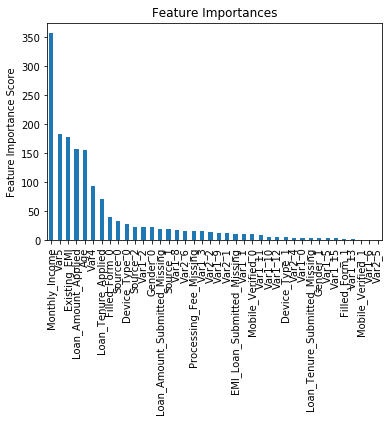

In [8]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        objective= 'binary:logistic',
        scale_pos_weight=1,
        seed=27,
        predictor = 'gpu_predictor', 
        tree_method = 'gpu_hist')
modelfit(xgb3, train, test, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.881015


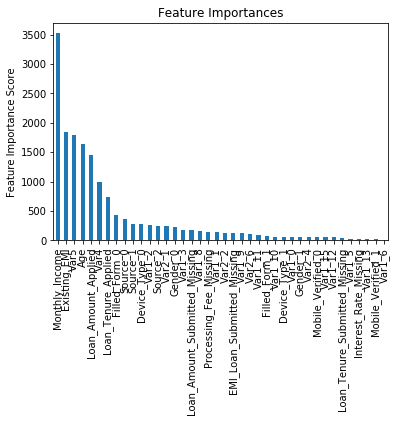

In [9]:
xgb4 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=4,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.005,
        objective= 'binary:logistic',
        scale_pos_weight=1,
        seed=27,
        predictor = 'gpu_predictor', 
        tree_method = 'gpu_hist')
modelfit(xgb4, train, test, predictors)